### 集成学习

#### boosting- Adaboosting

In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [113]:
sns.set_style("whitegrid")

In [114]:
def get_simple_data():
    X = [[1, 2.1], [2, 1.1], [1.3, 1], [1, 1], [2, 1]]
    y = [1.0, 1.0, -1, -1, 1]
    return X, y

In [115]:
X,y=get_simple_data()
X,y

([[1, 2.1], [2, 1.1], [1.3, 1], [1, 1], [2, 1]], [1.0, 1.0, -1, -1, 1])

In [116]:
X=np.array(X)

In [117]:
y=np.array(y)

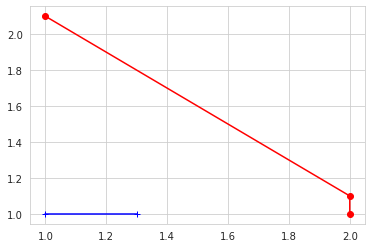

In [118]:
plt.plot(X[y==1,0],X[y==1,1],color='r',marker='o')
plt.plot(X[y==-1,0],X[y==-1,1],color='b',marker='+')

In [119]:
X[y==-1]

array([[1.3, 1. ],
       [1. , 1. ]])

In [120]:
def stump_classify(X_Mar, dimen, thresh_val, thresh_ineq):
    res = np.ones((np.shape(X_Mar)[0], 1))
    if thresh_ineq == 'lt':
        res[X_Mar[:, dimen] <= thresh_val] = -1.0
    else:
        res[X_Mar[:, dimen] > thresh_val] = -1.0
    return res

In [121]:
def build_strump(X, y, D):
    """
        X: 特征
        y: 标签
    """
    X = np.mat(X)
    y = np.mat(y).T
    m, n = np.shape(X)
    num_steps = 10.0
    # 最佳单层决策树
    best_stump = {}
    best_class_est = np.mat(np.zeros((m, 1)))
    min_error = np.inf
    for i in range(n):
        range_min = X[:, i].min()
        range_max = X[:, i].max()
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1):
            for inequal in ['lt', 'gt']:
                thresh_val = (range_min + j * step_size)
                pred_vals = stump_classify(X, i, thresh_val, inequal)
                error_arr = np.mat(np.ones((m, 1)))
                error_arr[pred_vals == y] = 0
                weight = D.T * error_arr

                # 权重误差小于min,return
                if weight < min_error:
                    min_error = weight
                    best_class_est = pred_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_class_est

In [122]:
D=np.mat(np.ones((5,1))/5)
D

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [123]:
build_strump(X,y,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

##### 完整的adaboost
1. 初始化权值
2. 遍历所有特征
    - 2.1 使用初始化权值分布的训练集学习得到基学习器
    - 2.2 计算基学习器的误差率
    - 2.3 计算G(m)的系数
    - 2.4 更新样本权重系数
3. 输出模型

In [124]:
def adaboost(X, y, iter_nums=40):
    weak_class = []
    m = np.shape(X)[0]
    # 1. init D
    D = np.mat(np.ones((m, 1)) / m)
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(iter_nums):
        best_stump, error, class_est = build_strump(X, y, D)
        #print("D.T: ", D.T)
        #calc alpha, throw in max(error,eps) to account for error=0
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        #print("alpha:\n", alpha)
        best_stump['alpha'] = alpha
        #store Stump Params in Array
        weak_class.append(best_stump)
        #print("class_est:", class_est.T)
        #exponent for D calc, getting messy
        expon = np.multiply(-1 * alpha * np.mat(y).T, class_est)
        #Calc New D for next iteration
        D = np.multiply(D, np.exp(expon))
        D /= D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        agg_class_est += alpha * class_est
        #print("agg_class_est:", agg_class_est.T)
        agg_errors = np.multiply(
            np.sign(agg_class_est) != np.mat(y).T, np.ones((m, 1)))
        # print("agg_errors:",agg_errors)
        error_rate = agg_errors.sum() / m
        #print("total_error:", error_rate)
        if error_rate == 0.0:
            break
    return weak_class, agg_class_est

In [125]:
weak_class, agg_class_est=adaboost(X,y,9)
weak_class, agg_class_est

([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

In [126]:
def adaboost_classify(X, classifier_arr):
    # do stuff similar to last aggClassEst in adaBoostTrainDS
    X = np.mat(X)  #
    m = np.shape(X)[0]
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(len(classifier_arr)):
        class_est = stump_classify(X,classifier_arr[i]['dim'],\
                                 classifier_arr[i]['thresh'],\
                                 classifier_arr[i]['ineq'])#call stump classify
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        #print(agg_class_est)
    return np.sign(agg_class_est)

In [127]:
y_pred=adaboost_classify(X,weak_class)
y_pred

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [128]:
y_pred

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [129]:
y

array([ 1.,  1., -1., -1.,  1.])

In [130]:
adaboost_classify([0,0],weak_class)

matrix([[-1.]])

In [131]:
adaboost_classify([[5,5],[0,0]],weak_class)

matrix([[ 1.],
        [-1.]])

In [132]:
!ls datasets/

dating_test1.txt  email		      horseColicTraining.txt  svm_RBF2.txt
dating_test.txt   horse-colic.data    housing.csv	      svm_RBF.txt
digits		  horseColicTest.txt  play		      svm.txt


In [133]:
horse_train=pd.read_csv("datasets/horseColicTraining.txt",sep='\t',header=None).to_numpy()
X_train,y_train=horse_train[:,:-1],horse_train[:,-1]

In [134]:
def get_data(file_path):
    horse_train = pd.read_csv(file_path, sep='\t', header=None).to_numpy()
    X, y = horse_train[:, :-1], horse_train[:, -1]
    y[y == 0] = -1
    return X, y

In [135]:
X_train,y_train=get_data("datasets/horseColicTraining.txt")
X_train,y_train

(array([[ 2. ,  1. , 38.5, ...,  8.4,  0. ,  0. ],
        [ 1. ,  1. , 39.2, ..., 85. ,  2. ,  2. ],
        [ 2. ,  1. , 38.3, ...,  6.7,  0. ,  0. ],
        ...,
        [ 1. ,  1. , 37.5, ...,  6.8,  0. ,  0. ],
        [ 1. ,  1. , 36.5, ...,  6. ,  3. ,  3.4],
        [ 1. ,  1. , 37.2, ..., 62. ,  1. ,  1. ]]),
 array([-1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
        -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
         1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,
        -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        -1.,  1.,  1.,

In [136]:
X_test,y_test=get_data("datasets/horseColicTest.txt")
X_test,y_test

(array([[ 2. ,  1. , 38.5, ...,  6.3,  0. ,  0. ],
        [ 2. ,  1. , 37.6, ...,  6.3,  1. ,  5. ],
        [ 1. ,  1. , 37.7, ..., 70. ,  3. ,  2. ],
        ...,
        [ 1. ,  1. , 38. , ..., 65. ,  3. ,  2. ],
        [ 2. ,  1. , 38. , ...,  5.8,  0. ,  0. ],
        [ 2. ,  1. , 37.6, ...,  6. ,  0. ,  0. ]]),
 array([ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
         1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         1., -1.]))

In [137]:
### 训练数据
# total_error: 0.2842809364548495
weak_class_1, _=adaboost(X_train,y_train,1)
# [{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}]
weak_class_1

[{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}]

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
y_pred_horse=adaboost_classify(X_test,weak_class_1)
# 0.7313432835820896
accuracy_score(y_test,y_pred_horse)

0.7313432835820896

In [140]:
X_train.shape

(299, 21)

In [141]:
X_test.shape,y_test.shape

((67, 21), (67,))

In [142]:
def analysics_ada(iter_num=10):
    weak_class, _=adaboost(X_train,y_train,iter_num)
    y_pred_horse=adaboost_classify(X_test,weak_class_1)
    # 0.7313432835820896
    #print("iter_num: ",iter_num)
    #print("iter_num: ",weak_class,accuracy_score(y_test,y_pred_horse))
    return weak_class,accuracy_score(y_test,y_pred_horse)

In [144]:
test_iter_nums=[1,10,50,100] # 500,1000,10000
for i in test_iter_nums:
    analysics_ada(i)

iter_num:  1
iter_num:  [{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}] 0.7313432835820896
iter_num:  10
iter_num:  [{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}, {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104}, {'dim': 3, 'thresh': 55.199999999999996, 'ineq': 'gt', 'alpha': 0.2868097320169577}, {'dim': 18, 'thresh': 62.300000000000004, 'ineq': 'lt', 'alpha': 0.23297004638939506}, {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213741}, {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020634}, {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.15227368997476778}, {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512}, {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353359405}, {'dim': 4, 'thresh': 28.799999999999997, 'ineq': 'lt', 'alpha': 0.12521587326132078}] 0.7313432835820896
iter_num:  50
iter_num:  [{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.461662